# Inference using SEI4RD model on UK data.

Here we showcase how data is loaded and handled for inference from 1st March until 23rd May. Data for inference until
 31st August is generated with the `Dataset_England.py` python script.

**Links:**
- NHS deaths, with age group: https://www.england.nhs.uk/statistics/statistical-work-areas/covid-19-daily-deaths/
- Government webpage with overall data on number positive, deaths and recovered, with no age information: https://coronavirus.data.gov.uk/#countries
- Timeline on UK measures: https://bfpg.co.uk/2020/04/covid-19-timeline/
- Google mobility data: https://www.google.com/covid19/mobility/ and how to extract it from pdf: https://github.com/pastelsky/covid-19-mobility-tracker
- Description on testing strategy: https://www.gov.uk/guidance/coronavirus-covid-19-information-for-the-public
- Old contact matrices: https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005697
- New contact matrices: https://www.medrxiv.org/content/10.1101/2020.02.16.20023754v2


# Load the contact matrices from Prem et al (2017)

https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005697

These are contact matrices for 5 years age groups, up to the age of 75, and a single age group from 75+. By comparing with the plots in the original Prem's work, I think each column represents the individual, and each row the number of contacts that the individual has with each age group. 

**If you convert the dataframe to numpy array, the first index refers to the individual, and the second to the contacts with other age groups.** This is what we want in our formulation. 

**Note:** entries are age-stratified expected number of contacts per day. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.transforms import Bbox
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
contact_matrix_all_locations = pd.read_excel("data/contact_matrices_152_countries/MUestimates_all_locations_2.xlsx", 
                                             sheet_name="United Kingdom of Great Britain", header=None)

In [3]:
contact_matrix_home = pd.read_excel("data/contact_matrices_152_countries/MUestimates_home_2.xlsx", 
                                             sheet_name="United Kingdom of Great Britain", header=None)
contact_matrix_school = pd.read_excel("data/contact_matrices_152_countries/MUestimates_school_2.xlsx", 
                                             sheet_name="United Kingdom of Great Britain", header=None)
contact_matrix_work = pd.read_excel("data/contact_matrices_152_countries/MUestimates_work_2.xlsx", 
                                             sheet_name="United Kingdom of Great Britain", header=None)
contact_matrix_other_locations = pd.read_excel("data/contact_matrices_152_countries/MUestimates_other_locations_2.xlsx", 
                                               sheet_name="United Kingdom of Great Britain", header=None)

### Check age groups matrix with the plots in Prem et al. (2017).
The first index refers to the individual, and the second to the contacts with other age groups

In [4]:
contact_matrix_school_ger = pd.read_excel("data/contact_matrices_152_countries/MUestimates_school_1.xlsx", 
                                             sheet_name="Germany", header=0)

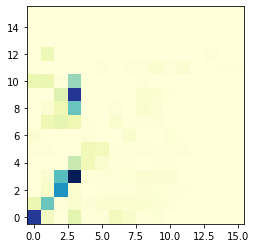

In [5]:
plt.imshow(contact_matrix_school_ger, cmap="YlGnBu", origin="lower")

In [6]:
print(contact_matrix_school_ger.to_numpy()[3,3], contact_matrix_school_ger.to_numpy()[9,3])

1.5420082024728454 1.341180359915077


# Contact matrices BBC (Klepac et al. (2020))

https://www.medrxiv.org/content/10.1101/2020.02.16.20023754v2

These are more recent (2018) contact matrices from a BBC study which involved more participants than the above one. Note however that the age groups are slightly different here for less than 24, and that there is not data up to 12 years old. 

These contact matrices consider the same 4 categories as above, but are moreover stratified also according to: 
- week/weekend.
- physical/conversational contact.

We have therefore more information here. It is however annoying data is not present for age < 12. 

In [7]:
contact_matrix_bbc_other = pd.read_excel("data/contact_matrices_BBC/BBC_contact_matrices.xls", 
                                             sheet_name="all_other", header=0, index_col=0)
contact_matrix_bbc_other_week = pd.read_excel("data/contact_matrices_BBC/BBC_contact_matrices_week.xls", 
                                             sheet_name="all_other", header=0, index_col=0)
contact_matrix_bbc_other_weekend = pd.read_excel("data/contact_matrices_BBC/BBC_contact_matrices_weekend.xls", 
                                             sheet_name="all_other", header=0, index_col=0)

/home/lorenzo/venv/epidemics/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  # This is added back by InteractiveShellApp.init_path()
/home/lorenzo/venv/epidemics/lib/python3.7/site-packages/mpl_toolkits/axes_grid1/axes_grid.py:51: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


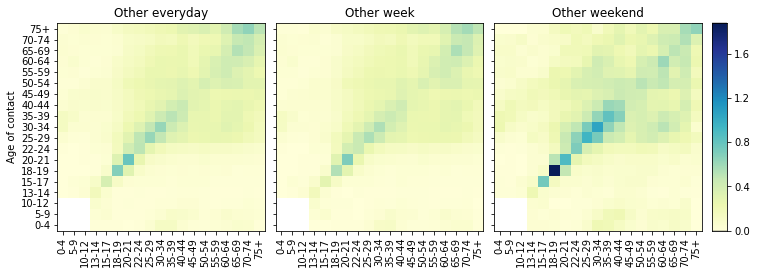

In [8]:
vmax = max(max(np.max(contact_matrix_bbc_other)), max(np.max(contact_matrix_bbc_other_week)), max(np.max(contact_matrix_bbc_other_weekend)))

fig = plt.figure(figsize=(12, 4))

ax = ImageGrid(fig, 111, nrows_ncols=(1,3), axes_pad=0.15, share_all=True, cbar_location="right",
                 cbar_mode="single", cbar_size="7%",cbar_pad=0.15)

ax[0].imshow(contact_matrix_bbc_other, vmax=vmax, cmap="YlGnBu", origin="lower")
ax[1].imshow(contact_matrix_bbc_other_week, vmax=vmax, cmap="YlGnBu", origin="lower")
im = ax[2].imshow(contact_matrix_bbc_other_weekend, vmax=vmax, cmap="YlGnBu", origin="lower")
ax[2].cax.colorbar(im)
ax[2].cax.toggle_label(True)

ax[0].set_title("Other everyday")
ax[1].set_title("Other week")
ax[2].set_title("Other weekend")
ax[0].set_ylabel("Age of contact")
for i in range(3):
    ax[i].set_xticks(np.arange(len(contact_matrix_bbc_other.columns.to_numpy())))
    ax[i].set_yticks(np.arange(len(contact_matrix_bbc_other.columns.to_numpy())))
    ax[i].set_xticklabels(contact_matrix_bbc_other.columns.to_numpy(), rotation="vertical")
    ax[i].set_yticklabels(contact_matrix_bbc_other.columns.to_numpy())

Age groups: 

In [9]:
contact_matrix_bbc_other.columns.to_numpy()

array(['0-4', '5-9', '10-12', '13-14', '15-17', '18-19', '20-21', '22-24',
       '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59',
       '60-64', '65-69', '70-74', '75+'], dtype=object)

They are also split by contact type: 

In [10]:
contact_matrix_bbc_home_physical = pd.read_excel("data/contact_matrices_BBC/BBC_contact_matrices.xls", 
                                             sheet_name="physical_home", header=0, index_col=0)
contact_matrix_bbc_home_conversational = pd.read_excel("data/contact_matrices_BBC/BBC_contact_matrices.xls", 
                                             sheet_name="conversational_home", header=0, index_col=0)
contact_matrix_bbc_home_all = pd.read_excel("data/contact_matrices_BBC/BBC_contact_matrices.xls", 
                                             sheet_name="all_home", header=0, index_col=0)

/home/lorenzo/venv/epidemics/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  if sys.path[0] == '':


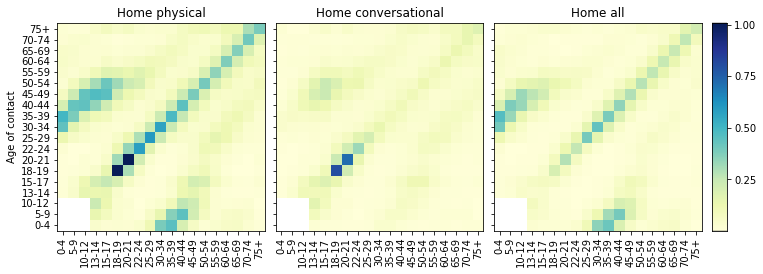

In [11]:
vmax = max(max(np.max(contact_matrix_bbc_home_physical)), max(np.max(contact_matrix_bbc_home_conversational)), max(np.max(contact_matrix_bbc_home_all)))

fig = plt.figure(figsize=(12, 4))

ax = ImageGrid(fig, 111, nrows_ncols=(1,3), axes_pad=0.15, share_all=True, cbar_location="right",
                 cbar_mode="single", cbar_size="7%",cbar_pad=0.15)

im = ax[2].imshow(contact_matrix_bbc_home_physical, vmax=vmax, cmap="YlGnBu", origin="lower")
ax[1].imshow(contact_matrix_bbc_home_conversational, vmax=vmax, cmap="YlGnBu", origin="lower")
ax[0].imshow(contact_matrix_bbc_home_all, vmax=vmax, cmap="YlGnBu", origin="lower")

ax[2].cax.colorbar(im)
ax[2].cax.toggle_label(True)

ax[2].set_title("Home all")
ax[1].set_title("Home conversational")
ax[0].set_title("Home physical")
ax[0].set_ylabel("Age of contact")
for i in range(3):
    ax[i].set_xticks(np.arange(len(contact_matrix_bbc_other.columns.to_numpy())))
    ax[i].set_yticks(np.arange(len(contact_matrix_bbc_other.columns.to_numpy())))
    ax[i].set_xticklabels(contact_matrix_bbc_other.columns.to_numpy(), rotation="vertical")
    ax[i].set_yticklabels(contact_matrix_bbc_other.columns.to_numpy())

Here the indices are the converse with respect to the other matrices: **the first one is the age of the contact, the second one is the age of individual. Then we need to transpose the matrices if we want to use them in same way as before.**

## Fill missing square: 
Follow what they do in the paper presenting the BBC matrices, namely: 

> 1. we take the ages 13 and 14 for which we have data to be representative of the entire age-group 10-14
> 2. we fill out the information for the age-groups 0-4 and 5-9 from POLYMOD by scaling the missing square with the ratio of dominant eigenvalues of the symmetric subset of the BBC matrix without missing values, and the same subset of the POLYMOD matrix. The scaling factor $q =\rho(\text{BBC}_S )/\rho(\text{POLYMOD}_S )$ where $S$ designates this symmetric subset of the matrix and $\rho()$ is the dominant eigenvalue (spectral radius) ensures that the dominant eigenvalue of the filled in BBC matrix stays intact.


However, note that we do not have data for the POLYMOD study splitted by physical/conversational contacts and by week/weekend, even if that should be available somewhere online.

Moreover, they provide BBC matrices with the first step done with the Supplementary Material for the BBC paper, only for the week; however, they do not do the second step. These matrices "with POLYMOD breaks" also rescale the other age groups to the 5-years age group. 

However, there is an issue, namely that they use a single age group for 70+ isntead of 70-74 and 75+ as in the POLYMOD matrices. It would be indeed possible to fix this issue by coarsening the original BBC matrices; another option is instead leave it as it is and use the 70+ category in the following coarsening for the ages; this would not change too much the final result, I expect. 


In [12]:
contact_matrix_bbc_school_polymod_breaks= pd.read_excel("data/contact_matrices_BBC/BBC_contact_matrices_polymod_breaks.xls", 
                                             sheet_name="all_school", header=0, index_col=0)
contact_matrix_bbc_other_polymod_breaks= pd.read_excel("data/contact_matrices_BBC/BBC_contact_matrices_polymod_breaks.xls", 
                                             sheet_name="all_other", header=0, index_col=0)
contact_matrix_bbc_home_polymod_breaks= pd.read_excel("data/contact_matrices_BBC/BBC_contact_matrices_polymod_breaks.xls", 
                                             sheet_name="all_home", header=0, index_col=0)
contact_matrix_bbc_work_polymod_breaks= pd.read_excel("data/contact_matrices_BBC/BBC_contact_matrices_polymod_breaks.xls", 
                                             sheet_name="all_work", header=0, index_col=0)

In [13]:
contact_matrix_bbc_school_polymod_breaks.columns

Index(['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39',
       '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70+'],
      dtype='object')

Fill now the 2x2 square: 

In [14]:
def fill_missing_square(bbc_matrix_polymod_breaks, polymod_matrix):
    # dominant eigvalue of BBC matrix: 
    eig_bbc = np.real(np.linalg.eig(bbc_matrix_polymod_breaks.iloc[2:, 2:])[0][0])

    # dominant eigvalue of POLYMOD matrix: 
    eig_polymod = np.real(np.linalg.eig(polymod_matrix.iloc[2:, 2:])[0][0])
        
    bbc_matrix_polymod_breaks.iloc[0:2, :2] = polymod_matrix.iloc[:2,:2].transpose().to_numpy()*eig_bbc/eig_polymod    
    
    # eigvalue stays roughly intact: 
    # print(np.real(np.linalg.eig(bbc_matrix_polymod_breaks.iloc[:, :])[0][0]), eig_bbc)

In [15]:
fill_missing_square(contact_matrix_bbc_home_polymod_breaks, contact_matrix_home)
fill_missing_square(contact_matrix_bbc_work_polymod_breaks, contact_matrix_work)
fill_missing_square(contact_matrix_bbc_other_polymod_breaks, contact_matrix_other_locations)
fill_missing_square(contact_matrix_bbc_school_polymod_breaks, contact_matrix_school)

Transpose matrices for subsequent manipulation:

In [16]:
contact_matrix_home = contact_matrix_bbc_home_polymod_breaks.transpose()
contact_matrix_work = contact_matrix_bbc_work_polymod_breaks.transpose()
contact_matrix_school = contact_matrix_bbc_school_polymod_breaks.transpose()
contact_matrix_other_locations = contact_matrix_bbc_other_polymod_breaks.transpose()
contact_matrix_all_locations = contact_matrix_home + contact_matrix_work + contact_matrix_school + contact_matrix_other_locations

/home/lorenzo/venv/epidemics/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  


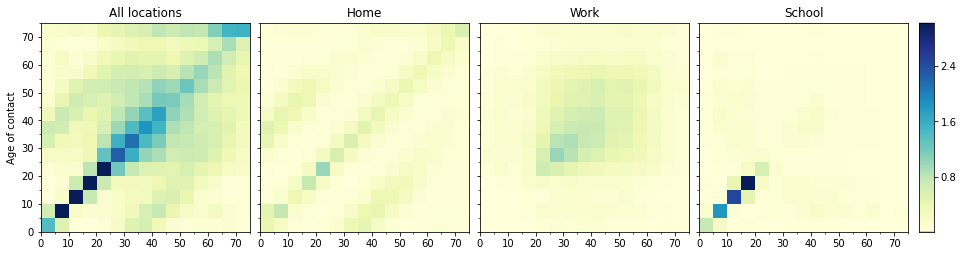

In [17]:
vmax = max(max(np.max(contact_matrix_home)), max(np.max(contact_matrix_work)), max(np.max(contact_matrix_school)), max(np.max(contact_matrix_other_locations)))

fig = plt.figure(figsize=(16, 4))

ax = ImageGrid(fig, 111, nrows_ncols=(1,4), axes_pad=0.15, share_all=True, cbar_location="right", 
                 cbar_mode="single", cbar_size="7%", cbar_pad=0.15)

ax[0].imshow(contact_matrix_all_locations.transpose(), vmax=vmax, cmap="YlGnBu", origin="lower")
ax[1].imshow(contact_matrix_home.transpose(), vmax=vmax, cmap="YlGnBu", origin="lower")
ax[2].imshow(contact_matrix_work.transpose(), vmax=vmax, cmap="YlGnBu", origin="lower")
im = ax[3].imshow(contact_matrix_school.transpose(), vmax=vmax, cmap="YlGnBu", origin="lower")
#im = ax[4].imshow(contact_matrix_other_locations.transpose(), vmax=vmax, cmap="YlGnBu", origin="lower")

ax[3].cax.colorbar(im)
ax[3].cax.toggle_label(True)

ax[0].set_title("All locations")
ax[1].set_title("Home")
ax[2].set_title("Work")
ax[3].set_title("School")
#ax[4].set_title("Other locations")
ax[0].set_ylabel("Age of contact")
for i in range(4):
    ax[i].set_xticks([-0.5, 1.5, 3.5, 5.5, 7.5, 9.5, 11.5, 13.5])#, 15.5])
    ax[i].set_yticks([-0.5, 1.5, 3.5, 5.5, 7.5, 9.5, 11.5, 13.5])#, 15.5])    
    ax[i].set_xticklabels([0, 10, 20, 30, 40, 50, 60, 70])#, 80])
    ax[i].set_yticklabels([0, 10, 20, 30, 40, 50, 60, 70])#, 80])    
    ax[i].set_xticks([0.5, 2.5, 4.5, 6.5, 8.5, 10.5, 12.5, 14.5], minor=True)
    ax[i].set_yticks([0.5, 2.5, 4.5, 6.5, 8.5, 10.5, 12.5, 14.5], minor=True)
#bbox_inches = Bbox(np.array([[2, 0.2], [18.2, 3.7]]))
savefig_kwargs = {"dpi": 250, "tightlayout": True}#, "bbox_inches": bbox_inches}
plt.savefig("data/UK_matrices.pdf", **savefig_kwargs)

# Data on UK population: 

From the office of national statistics, mid 2018 estimate: 

https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland

In [18]:
UK_pop = pd.read_excel("data/ukmidyearestimates20182019ladcodes.xls", sheet_name="MYE2-All", header=4)

In [19]:
UK_pop = UK_pop[UK_pop["Geography1"] == "Country"]
UK_pop

,Code,Name,Geography1,All ages,0,1,2,3,4,5,...,81,82,83,84,85,86,87,88,89,90
0,K02000001,UNITED KINGDOM,Country,66435550.0,745263.0,770614.0,796314.0,797183.0,804654.0,823204.0,...,362685.0,335716.0,308926.0,275717.0,251440.0,231588.0,207887.0,181142.0,152411.0,584024.0
1,K03000001,GREAT BRITAIN,Country,64553909.0,722107.0,746644.0,771397.0,772403.0,779741.0,797905.0,...,353509.0,327438.0,301355.0,268990.0,245130.0,226054.0,202985.0,176983.0,148734.0,570886.0
2,K04000001,ENGLAND AND WALES,Country,59115809.0,669797.0,692792.0,715313.0,715338.0,722190.0,739193.0,...,323241.0,299301.0,275483.0,245943.0,224531.0,207075.0,186581.0,163196.0,137054.0,528959.0
3,E92000001,ENGLAND,Country,55977178.0,637834.0,659890.0,681032.0,680758.0,687213.0,703391.0,...,304265.0,281645.0,259280.0,231314.0,211152.0,195247.0,175993.0,153958.0,129352.0,499276.0
362,W92000004,WALES,Country,3138631.0,31963.0,32902.0,34281.0,34580.0,34977.0,35802.0,...,18976.0,17656.0,16203.0,14629.0,13379.0,11828.0,10588.0,9238.0,7702.0,29683.0
385,S92000003,SCOTLAND,Country,5438100.0,52310.0,53852.0,56084.0,57065.0,57551.0,58712.0,...,30268.0,28137.0,25872.0,23047.0,20599.0,18979.0,16404.0,13787.0,11680.0,41927.0
418,N92000002,NORTHERN IRELAND,Country,1881641.0,23156.0,23970.0,24917.0,24780.0,24913.0,25299.0,...,9176.0,8278.0,7571.0,6727.0,6310.0,5534.0,4902.0,4159.0,3677.0,13138.0


We need to aggregate that in 20-years age groups: 

In [20]:
UK_pop["0-19"] = UK_pop.iloc[:,4:24].sum(axis=1)
UK_pop["20-39"] = UK_pop.iloc[:,24:44].sum(axis=1)
UK_pop["40-59"] = UK_pop.iloc[:,44:64].sum(axis=1)
UK_pop["60-79"] = UK_pop.iloc[:,64:84].sum(axis=1)
UK_pop["70-79"] = UK_pop.iloc[:,74:84].sum(axis=1)  # this is only used to rescale things
UK_pop["75-79"] = UK_pop.iloc[:,79:84].sum(axis=1)  # this is only used to rescale things
UK_pop["80+"] = UK_pop.iloc[:,84:95].sum(axis=1)

We now transform the contact matrices to that age groups as well. Need to do a weighted average on the individuals; moreover, that would be different for all of UK, England, Scotland... 

**Remember that first index represents individual, second age of contact.**

In [21]:
def transform_contact_matrix(contact_matrix, pop_df, region="ENGLAND"):
    # Remember that first index represents individual, second age of contact.  

    # define region populations
    region_pop_0_19 = pop_df[pop_df["Name"] == region]["0-19"].to_numpy()
    region_pop_20_39 = pop_df[pop_df["Name"] == region]["20-39"].to_numpy()
    region_pop_40_59 = pop_df[pop_df["Name"] == region]["40-59"].to_numpy()
    region_pop_60_79 = pop_df[pop_df["Name"] == region]["60-79"].to_numpy()
    region_pop_70_79 = pop_df[pop_df["Name"] == region]["70-79"].to_numpy()
    region_pop_75_79 = pop_df[pop_df["Name"] == region]["75-79"].to_numpy()
    region_pop_80 = pop_df[pop_df["Name"] == region]["80+"].to_numpy()

    # We first need to sum the age of contacts in blocks of 4; however, note that the last group in the contact
    # matrices is 70+, instead of 80+ as in the other work. We need therefore first to split the number of contacts 
    # there in the ones for 70+ and the ones for 80+; we assume they are equally spread. 
    
    # contact_matrix_1 = np.zeros((16, 17))
    contact_matrix_1 = np.zeros((15, 16))
    contact_matrix_1[:,0:-1] = contact_matrix.to_numpy()
    
    contact_matrix_1[:,-1] = contact_matrix_1[:,-2] * region_pop_80/(region_pop_80 + region_pop_70_79)
    contact_matrix_1[:,-2] = contact_matrix_1[:,-2] * region_pop_70_79/(region_pop_80 + region_pop_70_79)
    
    # Now we need to sum the number of contacts in groups of 4:    
    # contact_matrix_2 = np.zeros((16, 5)) 
    contact_matrix_2 = np.zeros((15, 5)) # row 14 now represents 70-79.
    
    for i in range(4):
        contact_matrix_2[:,i] = np.sum(contact_matrix_1[:,i*4:(i+1)*4], axis=1)
    contact_matrix_2[:,-1] = contact_matrix_1[:,-1]  # 80+ group
    
    # We now need to average over the age of individual, taking into account the number of people in each of the 5 years groups.
    contact_matrix_3 = np.zeros((5,5))     
    
    for i in range(4):
        tot_population_20y_age_group = 0
        for j in range(4): 
            tot_population_5y_age_group = 0
            for k in range(5):
                tot_population_5y_age_group += pop_df[pop_df["Name"]==region][20*i + 5*j +k].to_numpy()
                tot_population_20y_age_group += pop_df[pop_df["Name"]==region][20*i + 5*j +k].to_numpy()
            
            if i==3 and j==3:  # ad-hoc fix for the case of contact matrix with 70+ column
                contact_matrix_3[i,:] += tot_population_5y_age_group * contact_matrix_2[i*4 + j - 1,:]
            else: 
                contact_matrix_3[i,:] += tot_population_5y_age_group * contact_matrix_2[i*4 + j,:]

        contact_matrix_3[i,:] /= tot_population_20y_age_group
    
    contact_matrix_3[-1,:] = contact_matrix_2[-1,:]  # for individuals in the 80+ age group, we assume the contacts are the same as in the 70+ age group 
    
    return contact_matrix_3

In [22]:
contact_matrix_home_england = transform_contact_matrix(contact_matrix_home, UK_pop, region="ENGLAND")
contact_matrix_work_england = transform_contact_matrix(contact_matrix_work, UK_pop, region="ENGLAND")
contact_matrix_school_england = transform_contact_matrix(contact_matrix_school, UK_pop, region="ENGLAND")
contact_matrix_other_england = transform_contact_matrix(contact_matrix_other_locations, UK_pop, region="ENGLAND")
contact_matrix_all_england = contact_matrix_home_england + contact_matrix_work_england + contact_matrix_school_england + contact_matrix_other_england

Produce plot with overall matrix:

/home/lorenzo/venv/epidemics/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  from ipykernel import kernelapp as app


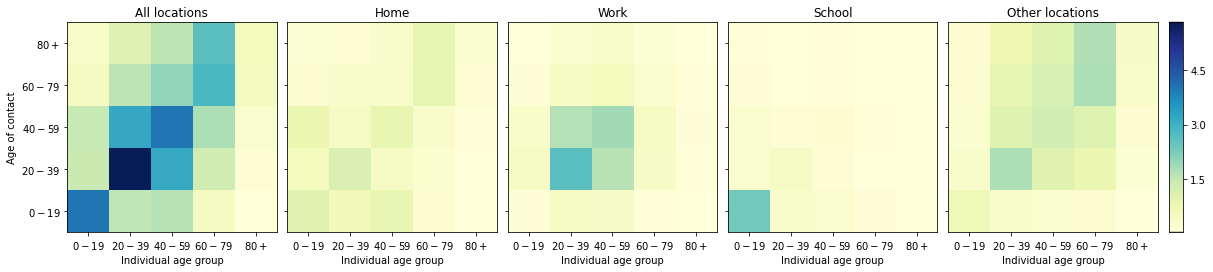

In [23]:
vmax = max(np.max(contact_matrix_all_england), np.max(contact_matrix_home_england), np.max(contact_matrix_work_england), np.max(contact_matrix_school_england), 
           np.max(contact_matrix_other_england))

fig = plt.figure(figsize=(20, 4))

ax = ImageGrid(fig, 111, nrows_ncols=(1,5), axes_pad=0.15, share_all=True, cbar_location="right", 
                 cbar_mode="single", cbar_size="7%", cbar_pad=0.15)

ax[0].imshow(contact_matrix_all_england, cmap="YlGnBu", vmax=vmax, origin="lower")
ax[1].imshow(contact_matrix_home_england, cmap="YlGnBu", vmax=vmax, origin="lower")
ax[2].imshow(contact_matrix_work_england, cmap="YlGnBu", vmax=vmax, origin="lower")
ax[3].imshow(contact_matrix_school_england, cmap="YlGnBu", vmax=vmax, origin="lower")
im = ax[4].imshow(contact_matrix_other_england, cmap="YlGnBu", vmax=vmax, origin="lower")

ax[4].cax.colorbar(im)
ax[4].cax.toggle_label(True)

ax[0].set_title("All locations")
ax[1].set_title("Home")
ax[2].set_title("Work")
ax[3].set_title("School")
ax[4].set_title("Other locations")
ax[0].set_ylabel("Age of contact")
for i in range(5):
#    ax[i].set_xticks([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
#    ax[i].set_yticks([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
#    ax[i].set_xticklabels([0, 20, 40, 60, 80])
#    ax[i].set_yticklabels([0, 20, 40, 60, 80])    
    ax[i].set_xticks([0,1,2,3,4])
    ax[i].set_yticks([0,1,2,3,4])
    ax[i].set_xticklabels([r"$0-19$", r"$20-39$", r"$40-59$", r"$60-79$", r"$80+$"])
    ax[i].set_yticklabels([r"$0-19$", r"$20-39$", r"$40-59$", r"$60-79$", r"$80+$"])
    ax[i].set_xlabel("Individual age group")
bbox_inches = Bbox(np.array([[2, 0.2], [18.2, 3.7]]))
savefig_kwargs = {"dpi": 250, "tightlayout": False, "bbox_inches": bbox_inches}

Produce plot without overall matrix:

/home/lorenzo/venv/epidemics/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  
/home/lorenzo/venv/epidemics/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


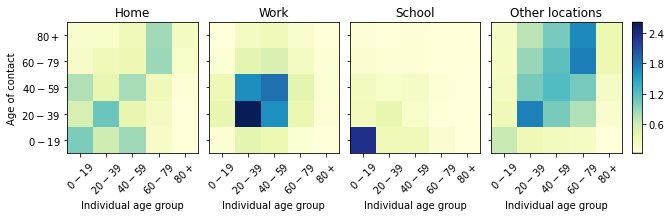

In [24]:
figsize_multiplier = 0.75
vmax = max(np.max(contact_matrix_home_england), np.max(contact_matrix_work_england), np.max(contact_matrix_school_england), np.max(contact_matrix_other_england))

fig = plt.figure(figsize=(16*figsize_multiplier, 4*figsize_multiplier))

ax = ImageGrid(fig, 111, nrows_ncols=(1,4), axes_pad=0.15, share_all=True, cbar_location="right", 
                 cbar_mode="single", cbar_size="7%", cbar_pad=0.15)

ax[0].imshow(contact_matrix_home_england, cmap="YlGnBu", vmax=vmax, origin="lower")
ax[1].imshow(contact_matrix_work_england, cmap="YlGnBu", vmax=vmax, origin="lower")
ax[2].imshow(contact_matrix_school_england, cmap="YlGnBu", vmax=vmax, origin="lower")
im = ax[3].imshow(contact_matrix_other_england, cmap="YlGnBu", vmax=vmax, origin="lower")

ax[3].cax.colorbar(im)
ax[3].cax.toggle_label(True)

ax[0].set_title("Home")
ax[1].set_title("Work")
ax[2].set_title("School")
ax[3].set_title("Other locations")
ax[0].set_ylabel("Age of contact")
for i in range(4):
#    ax[i].set_xticks([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
#    ax[i].set_yticks([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
#    ax[i].set_xticklabels([0, 20, 40, 60, 80])
#    ax[i].set_yticklabels([0, 20, 40, 60, 80])    
    ax[i].set_xticks([0,1,2,3,4])
    ax[i].set_yticks([0,1,2,3,4])
    ax[i].set_xticklabels([r"$0-19$", r"$20-39$", r"$40-59$", r"$60-79$", r"$80+$"], rotation=45)
    ax[i].set_yticklabels([r"$0-19$", r"$20-39$", r"$40-59$", r"$60-79$", r"$80+$"])
    ax[i].set_xlabel("Individual age group")
plt.tight_layout()
savefig_kwargs = {"dpi": 250}#, "tightlayout": True}#, "bbox_inches": bbox_inches}
plt.savefig("data/UK_matrices_aggregated.pdf", **savefig_kwargs)

# NHS: Daily deaths in England per age group: 

https://www.england.nhs.uk/statistics/statistical-work-areas/covid-19-daily-deaths/

From the notes in the webpage: 

> This section contains information on deaths of patients who have died in **hospitals** in England and had tested positive for COVID-19 at time of death. All deaths are recorded against the date of death rather than the date the deaths were announced. Interpretation of the figures should take into account the fact that totals by date of death, particularly for recent prior days, are likely to be updated in future releases. For example, as deaths are confirmed as testing positive for Covid-19, as more post-mortem tests are processed and data from them are validated. Any changes are made clear in the daily files.
>
> These figures will be updated at 2pm each day and include confirmed cases reported at 5pm the previous day. Confirmation of COVID-19 diagnosis, death notification and reporting in central figures can take up to several days and the hospitals providing the data are under significant operational pressure. This means that the totals reported at 5pm on each day may not include all deaths that occurred on that day or on recent prior days.
>
> **These figures do not include deaths outside hospital, such as those in care homes**. This approach makes it possible to compile deaths data on a daily basis using up to date figures. 

The age groups used here are bands of 20 ys, and then a single band for 80+. These need to be realigned with the contact matrix data. 

Note that you also have files containing the day of death which are announced on a given date.  

In [25]:
daily_deaths_age_group = pd.read_excel("data/COVID-19-total-announced-deaths-29-May-2020.xlsx", sheet_name="Tab3 Deaths by age", header=15, index_col=1)
daily_deaths_age_group = daily_deaths_age_group[daily_deaths_age_group.columns.drop(list(daily_deaths_age_group.filter(regex='Unna*')))]
daily_deaths_age_group = daily_deaths_age_group.iloc[:8].drop(index=daily_deaths_age_group.index[1])
daily_deaths_age_group = daily_deaths_age_group.fillna(0)

In [26]:
daily_deaths_age_group.iloc[:,1:-7]

,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,...,2020-05-14,2020-05-15,2020-05-16,2020-05-17,2020-05-18,2020-05-19,2020-05-20,2020-05-21,2020-05-22,2020-05-23
Age group,,,,,,,,,,,,,,,,,,,,,
Total,0.0,1.0,2.0,0.0,2.0,2.0,1.0,5.0,4.0,1.0,...,169.0,165.0,162.0,133.0,140.0,138.0,147.0,137.0,117.0,114.0
0 - 19 yrs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
20 - 39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
40 - 59,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,18.0,6.0,17.0,14.0,10.0,7.0,7.0,8.0,3.0,11.0
60 - 79,0.0,0.0,1.0,0.0,1.0,1.0,0.0,4.0,2.0,0.0,...,51.0,60.0,53.0,42.0,59.0,43.0,47.0,54.0,28.0,36.0
80+,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,100.0,98.0,92.0,76.0,69.0,88.0,93.0,75.0,86.0,67.0
TBC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The above is reliable until the 23rd May

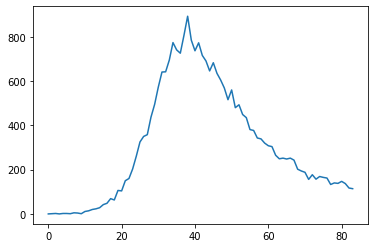

In [27]:
plt.plot(daily_deaths_age_group.iloc[0,1:-7].to_numpy())

# Data on hospitalized people: 
https://www.gov.uk/government/publications/slides-and-datasets-to-accompany-coronavirus-press-conference-25-may-2020

In [28]:
hospitalized_people = pd.read_excel("data/2020-05-28_COVID-19_Press_Conference_Data.xlsx", sheet_name="People in Hospital (UK)", header=4).dropna()

In [29]:
hospitalized_people["Region"].unique()

array(['East of England', 'London', 'Midlands', 'North East & Yorkshire',
       'North West', 'Scotland', 'South East', 'South West', 'Wales',
       'Northern Ireland'], dtype=object)

In [30]:
hospitalized_people_england = hospitalized_people[~hospitalized_people["Region"].isin(["Scotland", "Wales", "Nothern Ireland"])].groupby("Date").sum()

In [31]:
hospitalized_people_england.index[0]

Timestamp('2020-03-18 00:00:00')

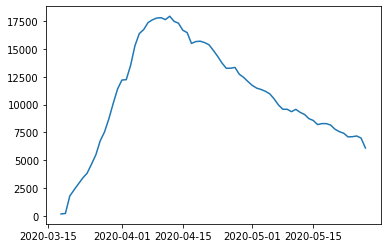

In [32]:
plt.plot(hospitalized_people_england)

In [33]:
hospitalized_people_england

,People in hospital
Date,
2020-03-18,193.0
2020-03-19,232.0
2020-03-20,1787.0
2020-03-21,2353.0
2020-03-22,2887.0
...,...
2020-05-23,7106.0
2020-05-24,7123.0
2020-05-25,7186.0


In [34]:
hospitalized_people_england.max()

People in hospital    17933.0
dtype: float64

### Create data with the number of hospitalized for ABCpy inference:
We create here data with the number of people in hospitals in England, for which we have data from the 18th March. Instead, number of deaths in hospital report data from the 1st March. Then we can build a dataset with those 2 starting from 1st March. 

In [35]:
daily_deaths_age_group.iloc[1:-1, 1:-7]

,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,...,2020-05-14,2020-05-15,2020-05-16,2020-05-17,2020-05-18,2020-05-19,2020-05-20,2020-05-21,2020-05-22,2020-05-23
Age group,,,,,,,,,,,,,,,,,,,,,
0 - 19 yrs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
20 - 39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
40 - 59,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,18.0,6.0,17.0,14.0,10.0,7.0,7.0,8.0,3.0,11.0
60 - 79,0.0,0.0,1.0,0.0,1.0,1.0,0.0,4.0,2.0,0.0,...,51.0,60.0,53.0,42.0,59.0,43.0,47.0,54.0,28.0,36.0
80+,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,100.0,98.0,92.0,76.0,69.0,88.0,93.0,75.0,86.0,67.0


In [36]:
daily_deaths_age_group_array = daily_deaths_age_group.iloc[1:-1, 1:-7].to_numpy()
number_days_with_hospitalized = daily_deaths_age_group_array.shape[1]

In [37]:
hospitalized_people_england_range = hospitalized_people_england[:"2020-05-23"]

In [38]:
len(hospitalized_people_england_range)

67

In [39]:
daily_deaths_age_group_array.shape

(5, 84)

In [40]:
observation_england = np.zeros((number_days_with_hospitalized, 6))
observation_england[-len(hospitalized_people_england_range):, -1] = hospitalized_people_england_range.to_numpy().reshape(-1)
observation_england[:-len(hospitalized_people_england_range), -1] = np.nan
observation_england[:,0:5] = daily_deaths_age_group_array.transpose(1,0)

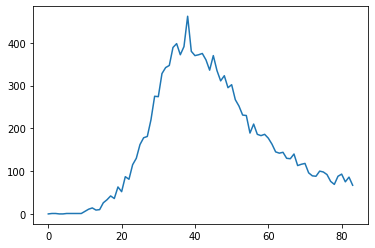

In [41]:
plt.plot(observation_england[:,4])

In [42]:
np.save("data/england_inference_data_1Mar_to_23May/observed_data", observation_england)

Save contact matrices and total population vector

In [43]:
np.save("data/england_inference_data_1Mar_to_23May/contact_matrix_home_england", contact_matrix_home_england)
np.save("data/england_inference_data_1Mar_to_23May/contact_matrix_work_england", contact_matrix_work_england)
np.save("data/england_inference_data_1Mar_to_23May/contact_matrix_school_england", contact_matrix_school_england)
np.save("data/england_inference_data_1Mar_to_23May/contact_matrix_other_england", contact_matrix_other_england)

In [44]:
np.save("data/england_inference_data_1Mar_to_23May/england_pop",  UK_pop.iloc[3, [-7, -6,-5,-4,-1]].to_numpy(dtype="float"))

# UK containment measures: 

This are described here: https://bfpg.co.uk/2020/04/covid-19-timeline/. We have the following main dates: 
- 16th March: Boris Johnson begins daily press briefings, urging everybody in the UK to work from home and avoid pubs and restaurants to give the NHS time to cope with the pandemic; he also announced that old people should self-isolate. 
- 20th March: The UK government orders all pubs, restaurants, gyms and other social venues across the country to close
- 23th March: schools and Universities are closed. 
- 23th March: Prime Minister Boris Johnson, in a televised address to the nation, says that Britons should only go outside to buy food, to exercise once a day, or to go to work if they absolutely cannot work from home. Citizens will face police fines for failure to comply with these new measures

We rely on the google mobility data: https://www.google.com/covid19/mobility/

You also have mobility data to a coarse spatial resolution. 

In [45]:
global_mobility = pd.read_csv("data/Global_Mobility_Report.csv")
global_mobility_UK = global_mobility[global_mobility["country_region"]=="United Kingdom"]
global_mobility_UK_whole = global_mobility_UK[global_mobility_UK["sub_region_1"].isna()]
global_mobility_UK_whole =global_mobility_UK_whole.set_index(global_mobility_UK_whole["date"])

/home/lorenzo/venv/epidemics/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [46]:
mobility_data_residential_raw = global_mobility_UK_whole["residential_percent_change_from_baseline"].to_frame().transpose()
mobility_data_workplaces_raw = global_mobility_UK_whole["workplaces_percent_change_from_baseline"].to_frame().transpose()
# data constituting the "other" category
mobility_data_parks_raw = global_mobility_UK_whole["parks_percent_change_from_baseline"].to_frame().transpose()
mobility_data_retail_and_recreation_raw = global_mobility_UK_whole["retail_and_recreation_percent_change_from_baseline"].to_frame().transpose()
mobility_data_transit_stations_raw = global_mobility_UK_whole["transit_stations_percent_change_from_baseline"].to_frame().transpose()
mobility_data_grocery_and_pharmacy_raw = global_mobility_UK_whole["grocery_and_pharmacy_percent_change_from_baseline"].to_frame().transpose()

The mobility data starts from 15th February. Then we assume that the contact matrices multipliers are 1 before that, and then we use some version of these data. We need to smooth a bit anyway. 

Try to smooth now the above curves: 

In [47]:
from scipy.signal import savgol_filter

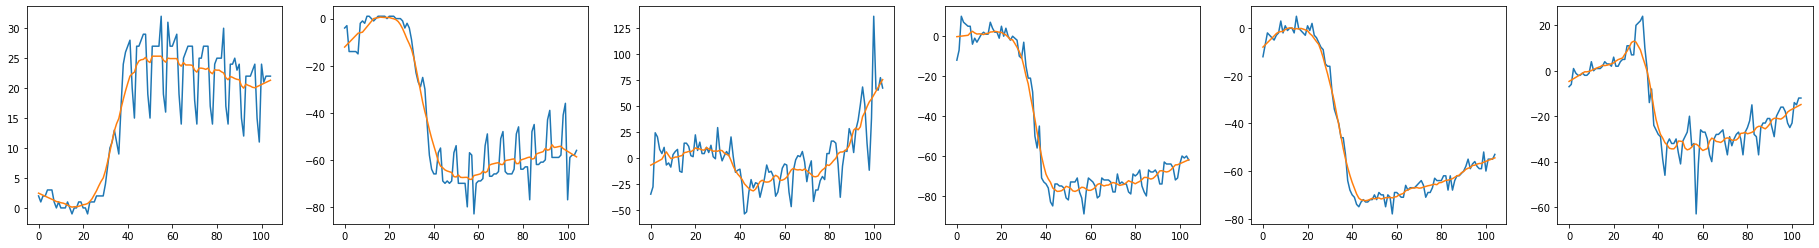

In [48]:
fig, ax = plt.subplots(ncols=6, figsize=(32,4))
ax[0].plot(mobility_data_residential_raw.to_numpy().reshape(-1))
ax[0].plot(savgol_filter(mobility_data_residential_raw.to_numpy().reshape(-1), 15, 1))
ax[1].plot(mobility_data_workplaces_raw.to_numpy().reshape(-1))
ax[1].plot(savgol_filter(mobility_data_workplaces_raw.to_numpy().reshape(-1), 13, 1))
ax[2].plot(mobility_data_parks_raw.to_numpy().reshape(-1))
ax[2].plot(savgol_filter(mobility_data_parks_raw.to_numpy().reshape(-1), 11, 1))
ax[3].plot(mobility_data_retail_and_recreation_raw.to_numpy().reshape(-1))
ax[3].plot(savgol_filter(mobility_data_retail_and_recreation_raw.to_numpy().reshape(-1), 11, 1))
ax[4].plot(mobility_data_transit_stations_raw.to_numpy().reshape(-1))
ax[4].plot(savgol_filter(mobility_data_transit_stations_raw.to_numpy().reshape(-1), 11, 1))
ax[5].plot(mobility_data_grocery_and_pharmacy_raw.to_numpy().reshape(-1))
ax[5].plot(savgol_filter(mobility_data_grocery_and_pharmacy_raw.to_numpy().reshape(-1), 11, 1))

We discard the part before the introduction of measures, and we assume that the multiplier was equal to 1. 


We take the multiplier to be constant until the 17th march, then we use the google data


In [49]:
def transform_alpha_df(df, window):
    zeros = pd.DataFrame(data = np.zeros((1,16)), columns=daily_deaths_age_group.columns[1:17])
    data = savgol_filter(df.to_numpy().reshape(-1), window, 1)
    y = pd.DataFrame(data.reshape(1,-1), columns=df.columns).iloc[:,31:]
    return pd.concat((zeros, y), axis=1)

In [50]:
mobility_data_residential = transform_alpha_df(mobility_data_residential_raw, 15)
mobility_data_workplaces = transform_alpha_df(mobility_data_workplaces_raw, 13)
mobility_data_parks = transform_alpha_df(mobility_data_parks_raw, 11)
mobility_data_retail_and_recreation = transform_alpha_df(mobility_data_retail_and_recreation_raw, 11)
mobility_data_transit_stations = transform_alpha_df(mobility_data_transit_stations_raw, 11)
mobility_data_grocery_and_pharmacy = transform_alpha_df(mobility_data_grocery_and_pharmacy_raw, 11)

Now transform that into the alpha multipliers; in order to form alpha_other, we combine data from the last 4 categories above, and assume contacts in park matter for 10%, while the others matter for 30% each. 

In [51]:
mobility_home_raw = 1 + mobility_data_residential_raw / 100.0
mobility_work_raw = 1 + mobility_data_workplaces_raw / 100.0
mobility_parks_raw = 1 + mobility_data_parks_raw / 100.0
mobility_retail_and_recreation_raw = 1 + mobility_data_retail_and_recreation_raw / 100.0
mobility_transit_stations_raw = 1 + mobility_data_transit_stations_raw / 100.0
mobility_grocery_and_pharmacy_raw = 1 + mobility_data_grocery_and_pharmacy_raw / 100.0

In [52]:
alpha_home = 1 + mobility_data_residential / 100.0
alpha_work = 1 + mobility_data_workplaces / 100.0
alpha_parks = 1 + mobility_data_parks / 100.0
alpha_retail_and_recreation = 1 + mobility_data_retail_and_recreation / 100.0
alpha_transit_stations = 1 + mobility_data_transit_stations / 100.0
alpha_grocery_and_pharmacy = 1 + mobility_data_grocery_and_pharmacy / 100.0

alpha_other = 0.1 * alpha_parks + 0.3*alpha_retail_and_recreation + 0.3*alpha_transit_stations + 0.3*alpha_grocery_and_pharmacy

For the schools: we reduce to alpha=0.1 for days from the 22nd March.

In [53]:
mobility_data_residential.columns

Index([2020-03-01 00:00:00, 2020-03-02 00:00:00, 2020-03-03 00:00:00,
       2020-03-04 00:00:00, 2020-03-05 00:00:00, 2020-03-06 00:00:00,
       2020-03-07 00:00:00, 2020-03-08 00:00:00, 2020-03-09 00:00:00,
       2020-03-10 00:00:00, 2020-03-11 00:00:00, 2020-03-12 00:00:00,
       2020-03-13 00:00:00, 2020-03-14 00:00:00, 2020-03-15 00:00:00,
       2020-03-16 00:00:00,        '2020-03-17',        '2020-03-18',
              '2020-03-19',        '2020-03-20',        '2020-03-21',
              '2020-03-22',        '2020-03-23',        '2020-03-24',
              '2020-03-25',        '2020-03-26',        '2020-03-27',
              '2020-03-28',        '2020-03-29',        '2020-03-30',
              '2020-03-31',        '2020-04-01',        '2020-04-02',
              '2020-04-03',        '2020-04-04',        '2020-04-05',
              '2020-04-06',        '2020-04-07',        '2020-04-08',
              '2020-04-09',        '2020-04-10',        '2020-04-11',
              '2020-

In [54]:
mobility_data_residential.columns[21]

'2020-03-22'

In [55]:
data = np.ones((1,alpha_other.shape[1]))
data[:,22:] = 0.1
alpha_school = pd.DataFrame(data = data, columns=alpha_other.columns)

In [56]:
ticks = [0, 15, 30, 45, 60, 75, 89]  #22
tickslabels = pd.to_datetime(mobility_data_residential.columns[ticks]).strftime("%d-%m")

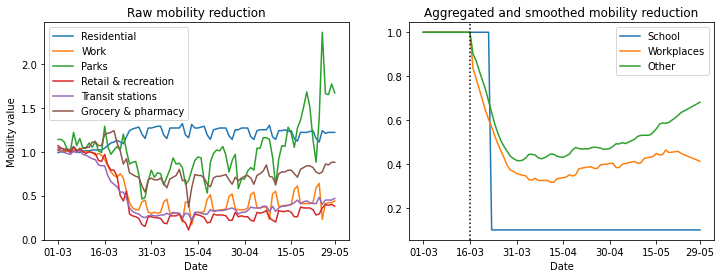

In [57]:
# raw data starts from 15th February, but we consider dynamics from 1st March. Then discard first 15 elements. 
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
ax[0].plot(mobility_home_raw.to_numpy().reshape(-1)[15:], label="Residential")
ax[0].plot(mobility_work_raw.to_numpy().reshape(-1)[15:], label="Work")
ax[0].plot(mobility_parks_raw.to_numpy().reshape(-1)[15:], label="Parks")
ax[0].plot(mobility_retail_and_recreation_raw.to_numpy().reshape(-1)[15:], label="Retail & recreation")
ax[0].plot(mobility_transit_stations_raw.to_numpy().reshape(-1)[15:], label="Transit stations")
ax[0].plot(mobility_grocery_and_pharmacy_raw.to_numpy().reshape(-1)[15:], label="Grocery & pharmacy")
ax[0].legend()
ax[0].set_xticks(ticks)
ax[0].set_xticklabels(tickslabels)
ax[0].set_title("Raw mobility reduction")
ax[0].set_xlabel("Date")
#ax[0].set_ylabel(r"$m$")
ax[0].set_ylabel("Mobility value")

ax[1].plot(alpha_school.to_numpy().reshape(-1), label="School")
ax[1].plot(alpha_work.to_numpy().reshape(-1), label="Workplaces")
ax[1].plot(alpha_other.to_numpy().reshape(-1), label="Other")
ax[1].legend()
ax[1].axvline(15, color="k", ls="dotted", label="Lockdown day")
#plt.axvline(22, color="k", ls="dotted", label="Lockdown day")
ax[1].set_xticks(ticks)
ax[1].set_xticklabels(tickslabels)
ax[1].set_title("Aggregated and smoothed mobility reduction")
ax[1].set_xlabel("Date")
ax[0].set_ylabel("Mobility value")

fig.savefig("data/mobility_data.pdf", bbox="tight")

Transform to numpy and add final steady states (more days with same value as the last day, up to the day for which we have data from UK government)

In [58]:
def df_alphas_to_np(df, number_days):
    array = np.zeros(number_days)
    array[:df.shape[1]] = df
    array[df.shape[1]:] = df.iloc[0,-1]
    return array

In [59]:
days_for_alphas = number_days_with_hospitalized
alpha_home_np = df_alphas_to_np(alpha_home.iloc[:,:84], days_for_alphas)
alpha_work_np = df_alphas_to_np(alpha_work.iloc[:,:84], days_for_alphas)
alpha_other_np = df_alphas_to_np(alpha_other.iloc[:,:84], days_for_alphas)
alpha_school_np = df_alphas_to_np(alpha_school.iloc[:,:84], days_for_alphas)

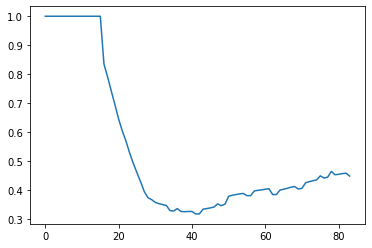

In [60]:
plt.plot(alpha_work_np)

In [61]:
np.save("data/england_inference_data_1Mar_to_23May/mobility_home", alpha_home_np)
np.save("data/england_inference_data_1Mar_to_23May/mobility_work", alpha_work_np)
np.save("data/england_inference_data_1Mar_to_23May/mobility_other", alpha_other_np)
np.save("data/england_inference_data_1Mar_to_23May/mobility_school", alpha_school_np)

## Additional mobility data after 23rd May:

We save here the mobility data from the 24th to the 29th of May: 

In [62]:
days_for_alphas = 6
alpha_home_np_after_23 = df_alphas_to_np(alpha_home.iloc[:,84:], days_for_alphas)
alpha_work_np_after_23 = df_alphas_to_np(alpha_work.iloc[:,84:], days_for_alphas)
alpha_other_np_after_23 = df_alphas_to_np(alpha_other.iloc[:,84:], days_for_alphas)
alpha_school_np_after_23 = df_alphas_to_np(alpha_school.iloc[:,84:], days_for_alphas)

In [63]:
np.save("data/england_inference_data_1Mar_to_23May/mobility_home_after_23", alpha_home_np_after_23)
np.save("data/england_inference_data_1Mar_to_23May/mobility_work_after_23", alpha_work_np_after_23)
np.save("data/england_inference_data_1Mar_to_23May/mobility_other_after_23", alpha_other_np_after_23)
np.save("data/england_inference_data_1Mar_to_23May/mobility_school_after_23", alpha_school_np_after_23)